# 1. Setup

In [1]:
import os
import time
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils
from torchvision.models import resnet18
from sklearn.metrics import accuracy_score, confusion_matrix

from PIL import Image

In [2]:
train_dir = 'Data/Train'
val_dir = 'Data/Val'
test_dir = 'Data/Test'

In [3]:
num_cpus = os.cpu_count()

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


# 2. Define dataset

In [5]:
transform_ops = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                ])

In [6]:
inverse_transform_ops = transforms.Compose([
                            transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
                        ])

In [7]:
trainset = datasets.ImageFolder(root=train_dir, transform=transform_ops)
valset = datasets.ImageFolder(root=val_dir, transform=transform_ops)
testset = datasets.ImageFolder(root=test_dir, transform=transform_ops)
print(len(trainset), len(valset), len(testset))

25000 1000 1000


In [8]:
train_loader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=num_cpus)
val_loader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=num_cpus)
test_loader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=num_cpus)
print(len(train_loader), len(val_loader), len(test_loader))

1563 63 63


# 3. Define ultilties

In [9]:
print(trainset.class_to_idx)
print(valset.class_to_idx)
print(testset.class_to_idx)

{'Hindi': 0, 'Malayalam': 1, 'Punjabi': 2, 'Tamil': 3, 'Telugu': 4}
{'Hindi': 0, 'Malayalam': 1, 'Punjabi': 2, 'Tamil': 3, 'Telugu': 4}
{'Hindi': 0, 'Malayalam': 1, 'Punjabi': 2, 'Tamil': 3, 'Telugu': 4}


In [10]:
class2idx = trainset.class_to_idx
idx2class = {v:k for k, v in class2idx.items()}
print(class2idx)
print(idx2class)

{'Hindi': 0, 'Malayalam': 1, 'Punjabi': 2, 'Tamil': 3, 'Telugu': 4}
{0: 'Hindi', 1: 'Malayalam', 2: 'Punjabi', 3: 'Tamil', 4: 'Telugu'}


In [11]:
def plot_image(image_tensor, title=""):
    """
    Arguments:
    image_tensor -- tensor of Size([1, n_h, n_w,]) / Size([3, n_h+4, n_w*m+4])
    """
    image_tensor = inverse_transform_ops(image_tensor)
    image_array = image_tensor.numpy().transpose(1, 2, 0)
    plt.figure(figsize=(20, 20))
    plt.imshow(image_array)
    plt.title(title)
    return plt.show()

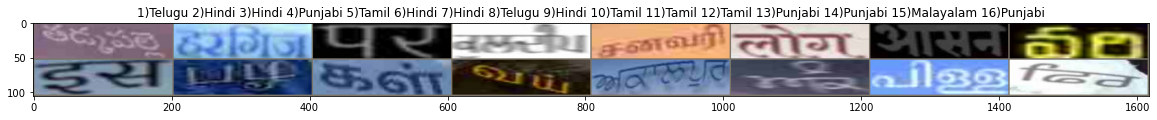

In [12]:
X, Y = iter(train_loader).next()
m = 16
image_grid = utils.make_grid(X[:m])
names = " ".join([f'{i}){idx2class[y.item()]}' for i, y in enumerate(Y[:m], start=1)])
plot_image(image_grid, title=names)

# 4. Define model

In [13]:
resnet = resnet18(pretrained=True)
for p in resnet.parameters():
    pass#p.requires_grad = False

In [14]:
class Model1(nn.Module):
    
    def __init__(self):
        
        super(Model, self).__init__()
        self.dp1 = nn.Dropout(p=0.5)
        self.dp2 = nn.Dropout(p=0.2)
        resnet_modules = list(resnet.children())[:-3]
        self.cnn = nn.Sequential(*resnet_modules)
        self.linear1 = nn.Linear(1024, 64)
        self.linear2 = nn.Linear(13*64, 32)
        self.out = nn.Linear(32, 5)
        
        
    def forward(self, batch):
        
        batch = self.cnn(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 13, 256, 4])
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 13, 1024])
        
        batch = self.linear1(batch)
        batch = self.dp1(batch)
        # print(batch.size()) # torch.Size([-1, 13, 64])
        batch = batch.view(batch_size, -1) 
        # print(batch.size()) # torch.Size([-1, 13*64])
            
        batch = self.linear2(batch)
        batch = self.dp2(batch)
        # print(batch.size()) # torch.Size([-1, 16])
        
        batch = self.out(batch) # [batch_size, num_classes]
        # print(batch.size()) # torch.Size([-1, 2])
        
        return batch

In [15]:
class Model2(nn.Module):
    
    def __init__(self, rnn_hidden_size=256):
        
        super(Model2, self).__init__()
        self.rnn_hidden_size = rnn_hidden_size
        self.dp1 = nn.Dropout(p=0.5)
        self.dp2 = nn.Dropout(p=0.4)
        self.dp3 = nn.Dropout(p=0.5)
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            num_layers=2,
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True,
                            num_layers=1, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, 16)
        self.out = nn.Linear(13*16, 5)
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        batch = self.dp1(batch)
        # print(batch.size())# torch.Size([-1, 256, 4, 13])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 13, 256, 4])
        
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 13, 1024])
        
        batch = self.linear1(batch)
        batch = self.dp2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn2(batch)
        batch = self.dp3(batch)
        # print(batch.size()) # torch.Size([-1, 13, 512])
        
        batch = self.linear2(batch)
        batch = self.dp3(batch)
        # print(batch.size()) # torch.Size([-1, 13, 16])
        
        # batch = batch[:, -1, :] 
        # print(batch.size()) # torch.Size([-1, 16])
        batch = batch.view(batch_size, -1) 
        # print(batch.size()) # torch.Size([-1, 13*16])
        
        batch = self.out(batch)
        # print(batch.size()) # torch.Size([-1, 5])
        
        return batch

# 5. Train model

In [16]:
train_batch_size = 64

lr = 0.0001
weight_decay = 0.01
step_size = 5
gamma = 0.9

num_epochs = 30
print_every = num_epochs // 10

In [17]:
model = Model2()
model = model.to(device)

In [18]:
weight = torch.Tensor([1., 1., 1., 1., 1.]).to(device)
criterion = nn.CrossEntropyLoss(reduction="mean", weight=weight)
optimizer = optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

In [19]:
epoch_losses = []
epoch_losses_val = []
epoch_lrs = []
iteration_losses = []
iteration_lrs = []

for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss = 0
    epoch_loss_val = 0
    epoch_lr = 0
    
    model.train()
    for X, Y in tqdm(train_loader, desc="Epoch-{}".format(epoch), leave=False):
        X, Y = X.to(device), Y.to(device)
        
        optimizer.zero_grad()
        Y_pred_logits = model(X)
        loss = criterion(Y_pred_logits, Y)
        loss.backward()
        optimizer.step()
        
        iteration_losses.append(loss.item())
        iteration_lrs.append(lr_scheduler.get_last_lr()[0])
        epoch_loss += loss.item()
        epoch_lr += lr_scheduler.get_last_lr()[0]
        
    model.eval()
    for X, Y in val_loader:
        X, Y = X.to(device), Y.to(device)
        Y_pred_logits = model(X)
        loss = criterion(Y_pred_logits, Y)
        epoch_loss_val += loss.item()
        
    lr_scheduler.step()
    epoch_loss /= len(train_loader)
    epoch_loss_val /= len(val_loader)
    epoch_lr /= len(train_loader)
    epoch_losses.append(epoch_loss)
    epoch_losses_val.append(epoch_loss_val)
    epoch_lrs.append(epoch_lr)
    
    if epoch % print_every == 0:    
        message = "Epoch:{}    TrainLoss:{}    ValLoss:{}    LR:{}".format(epoch, 
                                                                           epoch_loss, 
                                                                           epoch_loss_val, 
                                                                           epoch_lr)
        model_path = f'Models/Language-Classifier-e{epoch}.pth'
        torch.save(model.state_dict(), model_path)
        print(message)

Epoch:3    TrainLoss:0.22786637897807593    ValLoss:0.20709700716866386    LR:9.999999999999942e-05


Epoch:6    TrainLoss:0.13450761305755785    ValLoss:0.17174223124507873    LR:9.000000000000365e-05


Epoch:9    TrainLoss:0.10661625898111271    ValLoss:0.19418954683674705    LR:9.000000000000365e-05


Epoch:12    TrainLoss:0.07333294037188465    ValLoss:0.1749537426327902    LR:8.099999999999843e-05


Epoch:15    TrainLoss:0.07024550093284267    ValLoss:0.15823373044767078    LR:8.099999999999843e-05


Epoch:18    TrainLoss:0.05396678994194636    ValLoss:0.29524659637420897    LR:7.290000000000067e-05


Epoch:21    TrainLoss:0.04348394238006893    ValLoss:0.14707742631435394    LR:6.560999999999789e-05


Epoch:24    TrainLoss:0.037489320169979384    ValLoss:0.11615438404537383    LR:6.560999999999789e-05


Epoch:27    TrainLoss:0.03619107195031391    ValLoss:0.20096115424992547    LR:5.904900000000103e-05


Epoch:30    TrainLoss:0.0346012053700189    ValLoss:0.18597788020731912    LR:5.904900000000103e-05



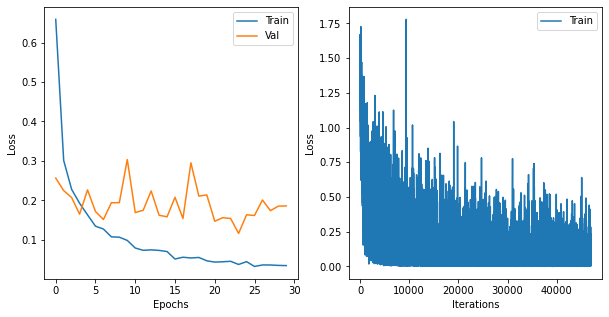

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses, label='Train')
ax1.plot(epoch_losses_val, label='Val')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(iteration_losses, label='Train')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

In [21]:
model_path = f'Models/Language-Classifier.pth'
torch.save(model.state_dict(), model_path)

# 6. Check Performance

In [36]:
model_path = f'Models/Language-Classifier-e24.pth' # Final Model
model = Model2()
model.load_state_dict(torch.load(model_path))
model.to(device)
model = model.eval()

In [37]:
def make_predictions(data_loader):
    result = pd.DataFrame(columns=['actual', 'prediction'])
    for X, Y in tqdm(data_loader, leave=False):
        X, Y = X.to(device), Y.to(device)
        Y_pred_logits = model(X)
        Y_pred = torch.argmax(Y_pred_logits, dim=1)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = Y.cpu().detach().numpy()
        df['prediction'] = Y_pred.cpu().detach().numpy()
        result = pd.concat([result, df])
    result = result.reset_index(drop=True)
    result['actual'] = result['actual'].map(idx2class)
    result['prediction'] = result['prediction'].map(idx2class)
    result['file_path'] = [sample[0] for sample in data_loader.dataset.samples]
    return result

In [38]:
train_loader = DataLoader(trainset, batch_size=64, shuffle=False, num_workers=num_cpus)
val_loader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=num_cpus)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=num_cpus)

train_result = make_predictions(train_loader)
val_result = make_predictions(val_loader)
test_result = make_predictions(test_loader)

In [39]:
print(train_result.shape)
print(val_result.shape)
print(test_result.shape)
train_result.head()

(25000, 3)
(1000, 3)
(1000, 3)


,actual,prediction,file_path
0,Hindi,Hindi,Data/Train/Hindi/अकसर_16_2891_0.jpg
1,Hindi,Hindi,Data/Train/Hindi/अगर_10_3664_2.jpg
2,Hindi,Hindi,Data/Train/Hindi/अगर_10_842_0.jpg
3,Hindi,Hindi,Data/Train/Hindi/अगर_12_1895_3.jpg
4,Hindi,Hindi,Data/Train/Hindi/अगर_12_2745_2.jpg


In [40]:
train_result.describe()

,actual,prediction,file_path
count,25000,25000,25000
unique,5,5,25000
top,Tamil,Hindi,Data/Train/Hindi/मगर_15_3797_2.jpg
freq,5000,5022,1


In [41]:
train_accuracy = accuracy_score(train_result['actual'], train_result['prediction'])
val_accuracy = accuracy_score(val_result['actual'], val_result['prediction'])
test_accuracy = accuracy_score(test_result['actual'], test_result['prediction'])
print(train_accuracy, val_accuracy, test_accuracy)

0.99564 0.957 0.957


In [42]:
cm = confusion_matrix(test_result['actual'], test_result['prediction'])
cm = pd.DataFrame(cm, index=idx2class.values(), columns=idx2class.values())
cm

,Hindi,Malayalam,Punjabi,Tamil,Telugu
Hindi,195,0,4,0,1
Malayalam,1,186,1,10,2
Punjabi,4,0,195,0,1
Tamil,0,6,3,190,1
Telugu,0,1,2,6,191


In [43]:
def visualize_misclassifications(result, num_samples=20):
    
    result = result[result.actual != result.prediction]
    result = result.sample(n = num_samples)
    for row_id, row in result.iterrows():
        image_fp = row['file_path']
        info = f'Actual: {row.actual};    Prediction: {row.prediction}'
        print(info)
        plt.imshow(Image.open(image_fp))
        plt.axis(False)
        plt.show() 

Actual: Tamil;    Prediction: Malayalam


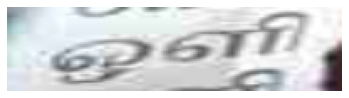

Actual: Tamil;    Prediction: Malayalam


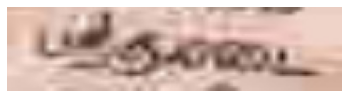

Actual: Tamil;    Prediction: Malayalam


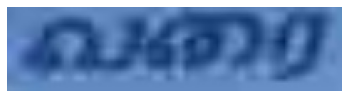

Actual: Malayalam;    Prediction: Tamil


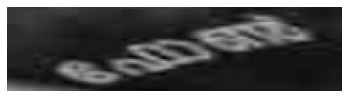

Actual: Tamil;    Prediction: Telugu


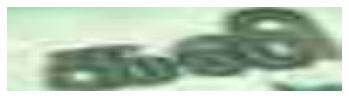

Actual: Malayalam;    Prediction: Hindi


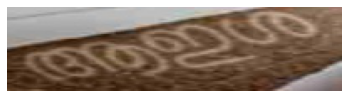

Actual: Malayalam;    Prediction: Tamil


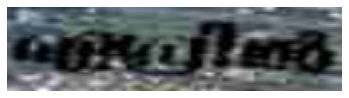

Actual: Telugu;    Prediction: Tamil


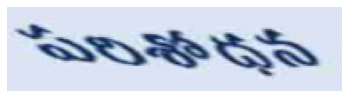

Actual: Punjabi;    Prediction: Telugu


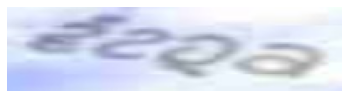

Actual: Hindi;    Prediction: Telugu


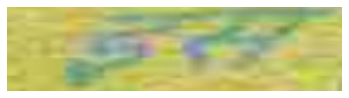

Actual: Malayalam;    Prediction: Punjabi


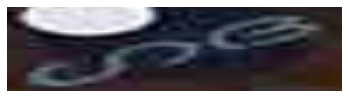

Actual: Malayalam;    Prediction: Tamil


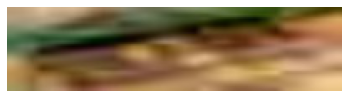

Actual: Telugu;    Prediction: Tamil


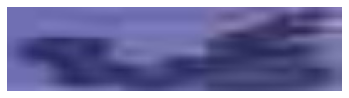

Actual: Telugu;    Prediction: Tamil


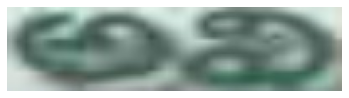

Actual: Malayalam;    Prediction: Telugu


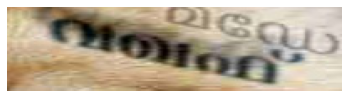

Actual: Telugu;    Prediction: Punjabi


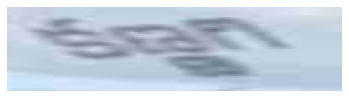

Actual: Punjabi;    Prediction: Hindi


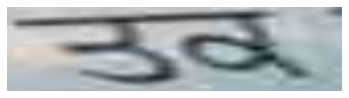

Actual: Tamil;    Prediction: Malayalam


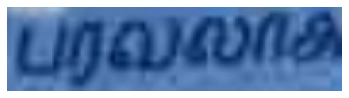

Actual: Telugu;    Prediction: Malayalam


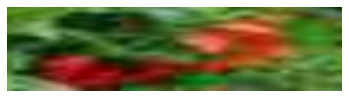

Actual: Malayalam;    Prediction: Tamil


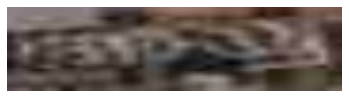

In [44]:
visualize_misclassifications(test_result, num_samples=20)

**References:**
1. https://github.com/GokulKarthik/Deep-Learning-Projects.pytorch